U.S. Census Bureau API with Python
======

## American Community Survey

----

*February 2026*<br>
*@bd_econ*

Using the [American Community Survey (ACS)](https://www.census.gov/programs-surveys/acs) 5-year estimates to examine demographic and economic patterns at the county and state level.

The list of available variables is [here](https://api.census.gov/data/2023/acs/acs5/variables.html). An API key (free) can be obtained from the [Census developer site](https://api.census.gov/data/key_signup.html).

In [1]:
import requests
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import config
key = config.census_key

### Example 1: Median Household Income by County

Fetch 2023 ACS 5-year estimates of median household income (`B19013_001E`) for all U.S. counties.

In [2]:
base = 'https://api.census.gov/data/'
year = '2023'
variables = {'NAME': 'Name',
             'B01001_001E': 'Population',
             'B19013_001E': 'Median Income'}
v = ','.join(variables.keys())

url = f'{base}{year}/acs/acs5?get={v}&for=county:*&in=state:*&key={key}'
r = requests.get(url).json()

df = pd.DataFrame(r[1:], columns=r[0]).rename(columns=variables)
df['FIPS'] = df['state'] + df['county']
df['Median Income'] = pd.to_numeric(df['Median Income'], errors='coerce')
df['Population'] = pd.to_numeric(df['Population'], errors='coerce')

# Census uses -666666666 as a sentinel for missing data
df.loc[df['Median Income'] < 0, 'Median Income'] = pd.NA

print(f'{len(df)} counties')
df[['Name', 'FIPS', 'Population', 'Median Income']].head()

3222 counties


,Name,FIPS,Population,Median Income
0,"Autauga County, Alabama",01001,59285,69841.0
1,"Baldwin County, Alabama",01003,239945,75019.0
2,"Barbour County, Alabama",01005,24757,44290.0
3,"Bibb County, Alabama",01007,22152,51215.0
4,"Blount County, Alabama",01009,59292,61096.0


#### Map the results

Merge the ACS data with a county-level TopoJSON file and plot using geopandas.

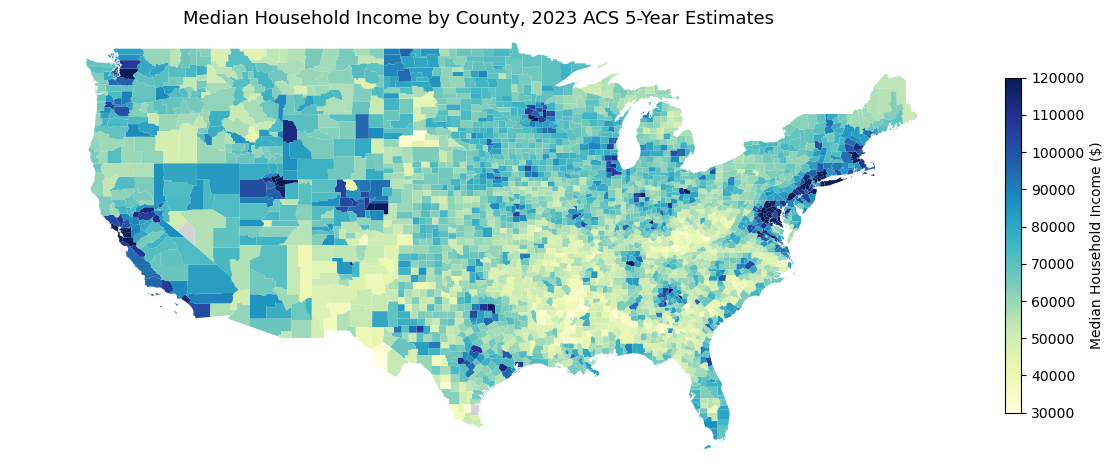

In [3]:
gdf = gpd.read_file('geo/us_counties.geojson')
merged = gdf.merge(df[['FIPS', 'Median Income']], on='FIPS', how='left')

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
merged.plot(column='Median Income', cmap='YlGnBu', legend=True, ax=ax,
            missing_kwds={'color': 'lightgray'}, edgecolor='none',
            vmin=30000, vmax=120000,
            legend_kwds={'shrink': 0.5, 'label': 'Median Household Income ($)'})
ax.set_xlim(-130, -65)
ax.set_ylim(24, 50)
ax.axis('off')
ax.set_title('Median Household Income by County, 2023 ACS 5-Year Estimates',
             fontsize=13)
plt.tight_layout()
plt.show()

### Example 2: Work from Home Rates by State

The ACS asks about commuting mode. Variable `B08301_021E` counts workers who work from home; `B08301_001E` is the total number of workers 16+. The ratio gives the work-from-home rate.

In [4]:
variables = {'NAME': 'Name',
             'B08301_001E': 'Total Workers',
             'B08301_021E': 'Work from Home'}
v = ','.join(variables.keys())

url = f'{base}{year}/acs/acs5?get={v}&for=state:*&key={key}'
r = requests.get(url).json()

df = pd.DataFrame(r[1:], columns=r[0]).rename(columns=variables)
df['Total Workers'] = pd.to_numeric(df['Total Workers'], errors='coerce')
df['Work from Home'] = pd.to_numeric(df['Work from Home'], errors='coerce')
df['WFH Rate'] = (df['Work from Home'] / df['Total Workers'] * 100).round(1)

df.nlargest(10, 'WFH Rate')[['Name', 'WFH Rate']]

,Name,WFH Rate
8,District of Columbia,29.4
5,Colorado,18.8
47,Washington,17.7
20,Maryland,17.2
37,Oregon,17.0
21,Massachusetts,16.7
2,Arizona,16.5
46,Virginia,16.2
44,Utah,16.0
23,Minnesota,15.8


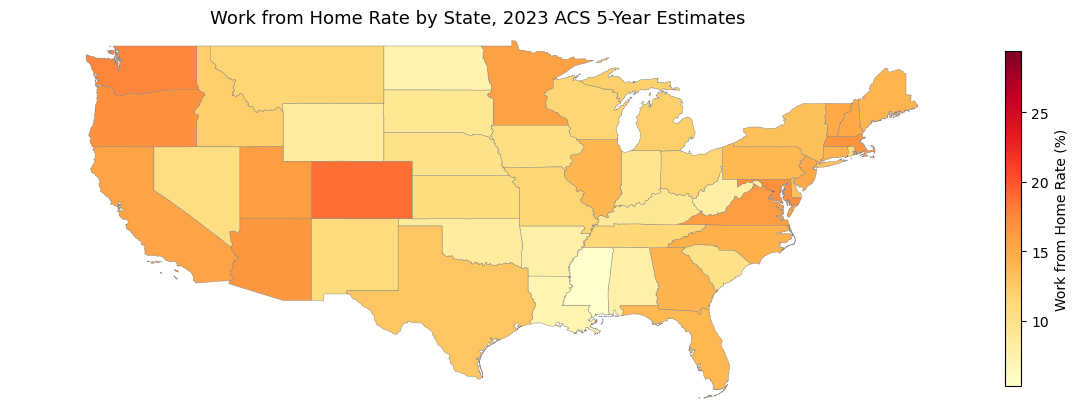

In [5]:
gdf = gpd.read_file('geo/us_states.topo.json')
merged = gdf.merge(df[['Name', 'WFH Rate']], left_on='NAME', right_on='Name', how='left')

fig, ax = plt.subplots(1, 1, figsize=(12, 7))
merged.plot(column='WFH Rate', cmap='YlOrRd', legend=True, ax=ax,
            missing_kwds={'color': 'lightgray'}, edgecolor='gray', linewidth=0.3,
            legend_kwds={'shrink': 0.5, 'label': 'Work from Home Rate (%)'})
ax.set_xlim(-130, -65)
ax.set_ylim(24, 50)
ax.axis('off')
ax.set_title('Work from Home Rate by State, 2023 ACS 5-Year Estimates',
             fontsize=13)
plt.tight_layout()
plt.show()